# word2vec

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

from gensim.models import word2vec
import config
from ast import literal_eval
import re
from nltk.corpus import stopwords
pd.set_option('display.max_colwidth', 100)

In [2]:
target = config.target_user
target_month = config.target_month
source_dir = "{}/data/twitter/tweets/{}".format(config.dir_prefix, target)
english_file = '/'.join([source_dir, target_month  + '_english.csv'])
english_file

'/home/key/code/python/twitter_topics/data/twitter/tweets/trivadis/2016-11_english.csv'

In [3]:
tweets_english = pd.read_csv(english_file, encoding='utf-8', 
                              usecols = ['id_str', 'user_id', 'created_at', 'lang', 'text', 'favorite_count', 'entities',
                                         'in_reply_to_screen_name', 'in_reply_to_status_id_str', 'in_reply_to_user_id',
                                         'retweet_count', 'quoted_status_id_str', 'text_tokenized', 'text_processed'],
                              converters={"text_tokenized": literal_eval, "text_processed": literal_eval})

def remove_hash(wordlist):
    return(list(map(lambda x: re.sub(r'^#','',x), wordlist)))

def remove_at(wordlist):
    return(list(map(lambda x: re.sub(r'^@','',x), wordlist)))

tweets_english['text_processed'] = tweets_english['text_processed'].apply(lambda x: list(map(lambda s: s.lower(),x)))
tweets_english['text_wo_#'] = tweets_english['text_processed'].apply(lambda x: remove_hash(x))
tweets_english['text_wo_#@'] = tweets_english['text_wo_#'].apply(lambda x: remove_at(x))

X_train_en = tweets_english['text_wo_#@'].apply(lambda x: ' '.join(x))
X_train_en[:10]

0    alphahelixsmc it appears that apple is still considering a foldable iphone would you use it http...
1    alphahelixsmc it appears that apple is still considering a foldable iphone would you use it http...
2                             dsgersten learn more about vfiorg and csecoalition https://t.co/lehzvz0vzj
3    windows 10 deployment tools techniques and processes the must-know concepts for it professionals...
4    vcpkg updates static linking is now available one month ago we announced the availability of vcp...
5    iamcporg make sure to sign up for the webinar 3 superpowers of p2p the practice the profits and ...
6    justinslagle so many of my microsoft partners have been waiting for this microsoftteams has arri...
7    smbinsiderjoe us smb marketing events lead davidcu206 on the latest episode of offpremwithterry ...
8     jon_rivers microsoft launches teams to take on slack https://t.co/nvfxbtgxge teams microsoft iamcp
9    iamcptpa join the iamcp tampa chapter meeting on 1

#### Try both with and without stop word removal 

In [4]:
stopwords_nltk = set(stopwords.words("english"))
relevant_words = set(['not', 'nor', 'no', 'wasn', 'ain', 'aren', 'very', 'only', 'but', 'don', 'isn', 'weren'])
#relevant_words = set()
additional_stopwords = set(['us'])
stopwords_filtered = list(additional_stopwords.union(stopwords_nltk.difference(relevant_words)))

In [5]:
sentences = []  
for tweet in X_train_en:
    words = tweet.split()
    sentences += [[word for word in words if word not in stopwords_filtered]]
    #sentences += [words]

In [6]:
len(sentences), len(sentences[0])

(8848, 10)

In [7]:
num_features = 100    # Word vector dimensionality                      
min_word_count = 1   # Minimum word count                        
num_workers = 2       # Number of threads to run in parallel
context = 10          # Context window size                                                                                    
downsampling = 1e-3   # Downsample setting for frequent words
model = word2vec.Word2Vec(sentences, workers=num_workers, size=num_features, min_count = min_word_count,
window = context, sample = downsampling)

In [8]:
len(model.vocab)

17481

In [24]:
words = ['oracle', 'talend', 'microsoft', 'cloud', 'bigdata', 'machinelearning', 'deeplearning', 'iot', 
         'azure', 'cassandra', 'pdb', 'office', 'datastax', 'database', 'neo4j']
for w in words:
    print('{}:\n {}\n\n'.format(w,model.most_similar(w)))

oracle:
 [('12c', 0.9995741248130798), ('features', 0.999523401260376), ('oracledatabase', 0.9995065927505493), ('db12c', 0.9994137287139893), ('feature', 0.9993319511413574), ('upgrade', 0.9993008375167847), ('release', 0.9992023706436157), ('pdb', 0.9992001056671143), ('cloud', 0.9989839792251587), ('excellent', 0.9987954497337341)]


talend:
 [('5', 0.999801516532898), ('bigdata', 0.9997485876083374), ('iot', 0.9996521472930908), ('hadoop', 0.9996306896209717), ('key', 0.9995836019515991), ('advice', 0.9995220899581909), ('data', 0.9994640946388245), ('free', 0.9994405508041382), ('architecture', 0.9994056820869446), ('datascience', 0.9994000196456909)]


microsoft:
 [('miss', 0.9997556209564209), ('only', 0.9996922016143799), ('experts', 0.9996503591537476), ('know', 0.9996417760848999), ('need', 0.9996071457862854), ('services', 0.9994969367980957), ('connect', 0.9992175102233887), ('city', 0.9991834163665771), ('sessions', 0.9991538524627686), ('follow', 0.9990562200546265)]


cl

KeyError: "word 'datastax' not in vocabulary"

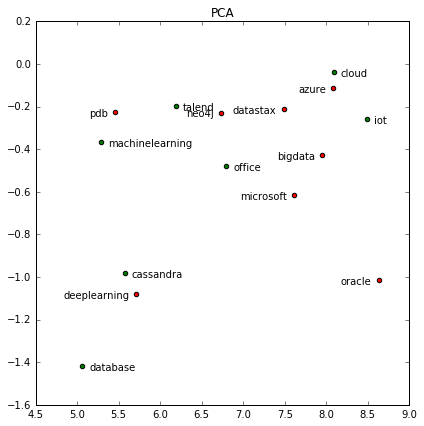

In [25]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
vectors = model.syn0

pca = PCA(n_components=2)
pca_2d = pca.fit_transform(vectors)


#tsne = TSNE(n_components=2, random_state=0, verbose=10, init='pca')
#tsne_2d = tsne.fit_transform(vectors)


first = True

#for name, transform in zip(['PCA', 'TSNE'], [pca_2d, tsne_2d]):  
for name, transform in zip(['PCA'], [pca_2d]):   
    plt.figure(figsize=(6,6))
    for point, word in zip(transform , words):
        plt.scatter(point[0], point[1], c='r' if first else 'g')
        plt.annotate(
            word, 
            xy = (point[0], point[1]),
            xytext = (-7, -6) if first else (7, -6),
            textcoords = 'offset points',
            ha = 'right' if first else 'left',
            va = 'bottom',
            size = "medium"
            )
        first = not first 
    plt.title(name)
    plt.tight_layout()
plt.show()

In [28]:
model.most_similar('datascience')

[('iot', 0.9995517730712891),
 ('bigdata', 0.9995294809341431),
 ('data', 0.9994615316390991),
 ('business', 0.9994568824768066),
 ('using', 0.9994338750839233),
 ('talend', 0.9994000196456909),
 ('every', 0.9993994832038879),
 ('analytics', 0.9993941783905029),
 ('free', 0.9993902444839478),
 ('future', 0.9993599057197571)]

In [29]:
model.most_similar('deeplearning')

[('little', 0.9970585703849792),
 ('slides', 0.9970086812973022),
 ('team', 0.9969937801361084),
 ('questions', 0.9969896078109741),
 ('beer', 0.9969820976257324),
 ('agile', 0.9969778060913086),
 ('many', 0.9969749450683594),
 ('use', 0.9969609379768372),
 ('since', 0.9969261884689331),
 ('code', 0.9969222545623779)]